COMIENZA CARGA DE DATOS

Cargo en primer lugar las librerias que usaré, luego cargo el set de datos elegido; este contiene datos de siniestros de tránsito en la Ciudad de Buenos Aires, entre los años 2015 y 2018. 

In [1]:
import numpy as np
import pandas as pd
import scipy.sparse as sp
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier

In [2]:
siniestros = 'victimas-siniestros.csv'
sin_df = pd.read_csv(siniestros)

C:\Users\Seguridad\AppData\Local\Temp\ipykernel_7852\1239150759.py:2: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  sin_df = pd.read_csv(siniestros)


COMIENZA EL PROCESO DE LIMPIEZA DEL DATASET

In [3]:
sin_df.head(3)

,causa,rol,tipo,sexo,edad,mes,periodo,fecha,hora,lugar_hecho,...,semestre,x,y,geom,cantidad_victimas,comuna,geom_3857,tipo_colision1,participantes_victimas,participantes_acusados
0,homicidio,conductor,moto,NaN,NaN,2.0,2015,2/14/2015,19:00:00,cafayate y severo garcia grande de zequeira,...,1,-58.508658,-34.653489,0101000020E610000057E042B51B414DC008419885A553...,1,9.0,0101000020110F0000DE9B958180D858C1EC802966CD68...,motovehiculo - vehiculo,moto,automovil
1,homicidio,NaN,NaN,NaN,NaN,2.0,2015,2/25/2015,3:00:00,"lugones, leopoldo av. y udaondo, guillermo av.",...,1,-58.447680,-34.543513,0101000020E6100000CC4C4C904D394DC0FAF382D99145...,1,13.0,0101000020110F0000BFBC457BDFD158C1E1DDA818C14B...,NaN,NaN,NaN
2,homicidio,peaton,peaton,femenino,NaN,2.0,2015,2/27/2015,8:00:00,avda jujuy y avda independencia,...,1,-58.403516,-34.618839,0101000020E6100000FBC35B67A6334DC03F854E1F364F...,1,3.0,0101000020110F0000F8067D6812CD58C189755F66A55F...,peaton - vehiculo,peaton,"""transporte publico"""


In [4]:
sin_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33234 entries, 0 to 33233
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   causa                         33234 non-null  object 
 1   rol                           32899 non-null  object 
 2   tipo                          32134 non-null  object 
 3   sexo                          33037 non-null  object 
 4   edad                          32675 non-null  float64
 5   mes                           33197 non-null  float64
 6   periodo                       33234 non-null  int64  
 7   fecha                         33173 non-null  object 
 8   hora                          33217 non-null  object 
 9   lugar_hecho                   29518 non-null  object 
 10  direccion_normalizada         32469 non-null  object 
 11  tipo_calle                    33234 non-null  object 
 12  direccion_normalizada_arcgis  32462 non-null  object 
 13  c

EN PRIMERA INSTANCIA DE LA EXPLORACION, VOY A ESTABLECER UN OBJETIVO GENERAL:

- QUIERO MINIMIZAR LA CANTIDAD DE ACCIDENTES DE AUTOS, MOTOS Y BICICLETAS (en este ejemplo me contrataría gobierno de la Ciudad de Buenos Aires). PARA ESTO HABRIA QUE TOMAR MEDIDAS DE TODO TIPO, COMO CONTROLES POLICIALES, CARTELES PREVENTIVOS, ARREGLOS DE CALLE, CAMARAS-MULTA, ETC.

-------------------------------------------------------------------------------------------------------------------------------

CON ESTE OBJETIVO EN MENTE, VOY A ELEGIR QUE COLUMNAS SON LAS QUE MAS INFORMACION PUEDEN APORTAR Y CUALES SON LAS QUE TIENEN INFORMACION REDUNDANTE.

EN UNA PRIMERA IMPRESION, ASUMO QUE LAS COLUMNAS MAS IMPORTANTES SON:

- causa
- rol
- tipo
- sexo
- edad
- fecha
- hora
- tipo_calle
- calle1
- calle2
- x
- y
- cantidad_victimas
- comuna
- participantes_victimas
- participantes_acusados

EL RESTO DE COLUMAS CONTIENEN INFORMACION QUE APARECE EN ESTAS COLUMNAS SELECCIONADAS, PERO EN OTRO FORMATO.

PROCEDO A QUEDARME SOLO CON LAS COLUMNAS ELEGIDAS Y REVISO LOS DATOS NULOS

In [5]:
sin_df = sin_df[['causa','rol','tipo','sexo','edad','fecha','hora','tipo_calle','calle1','calle2','x','y','cantidad_victimas','comuna','tipo_colision1','participantes_acusados','participantes_victimas']]
sin_df.isnull().sum()

causa                        0
rol                        335
tipo                      1100
sexo                       197
edad                       559
fecha                       61
hora                        17
tipo_calle                   0
calle1                     765
calle2                    8247
x                         1095
y                         1095
cantidad_victimas            0
comuna                    1098
tipo_colision1            1343
participantes_acusados     677
participantes_victimas    1131
dtype: int64

BORRO LAS FILAS QUE TIENEN EL CAMPO FECHA Y HORA VACIOS, PORQUE SON MUY POCOS DATOS QUE PIERDO.

In [6]:
sin_df.dropna(subset=['fecha','hora'],inplace=True)
sin_df[['fecha','hora']].isnull().sum()

fecha    0
hora     0
dtype: int64

AHORA VOY A SIMPLIFICAR LAS COLUMNAS 'tipo' Y 'tipo_colision1' PARA QUE SEAN UTILIZABLES.

In [7]:
sin_df['tipo_colision1'].fillna('sin_data',inplace=True)
sin_df['tipo'].fillna('sin_data',inplace=True)

def simplificar_tipocol(tipo):

    if '-' in tipo:
        ac, vi = tipo.split('-')
    else:
        return tipo
    
    if tipo == 'vehiculo - motovehiculo' or tipo == 'motovehiculo - vehiculo':
        return 'motovehiculo - vehiculo'
    elif tipo == 'vehiculo - peaton' or tipo == 'peaton - vehiculo':
        return 'peaton - vehiculo'
    elif tipo == 'vehiculo - bicicleta' or tipo == 'bicicleta - vehiculo':
        return 'bicicleta - vehiculo'
    elif tipo == 'traccion a sangre - vehiculo' or tipo == 'motovehiculo - traccion a sangre' or tipo == 'motovehiculo - tren' or tipo == 'subte - vehiculo':
        return 'sin_data'
    elif 'bicicleta' in tipo:
        return 'bicicleta'
    elif 'peaton' in tipo:
        return 'peaton'
    else:
        return tipo

def simplificar_tipo(tipo):
    
    if tipo == 'auto pfa / movil / gendarmeria / metropolitana / moto movil' or tipo == 'vehiculo oficial':
        st = 'fuerza seguridad'
    elif tipo == 'transporte de cargas / grua' or tipo == 'utilitario':
        st = 'camion'
    elif tipo == 'transporte escolar' or tipo == 'omnibus / minibus':
        st = 'transporte publico'
    elif tipo == 'ambulancia':
        st = 'camioneta'
    elif tipo == 'traccion a sangre' or tipo == 'autobomba' or tipo == 'patineta' or tipo == 'cuatriciclo' or tipo == 'tren / subte' or tipo == 'tren / subte / tranvia' or tipo == 'vehiculo rural' or tipo == 'otros':
        st = 'sin_data'
    else:
        return tipo
    return st

In [8]:
sin_df['tipo'] = sin_df['tipo'].apply(simplificar_tipo)#.astype('|S80')

sin_df['tipo_colision1'] = sin_df['tipo_colision1'].apply(simplificar_tipocol)#.astype('|S80')

sin_df[['tipo','tipo_colision1']].describe()

,tipo,tipo_colision1
count,33162,33162
unique,10,9
top,moto,motovehiculo - vehiculo
freq,12989,11378


DEBERIA RELLENAR LOS NULOS DE 'tipo' CON INFORMACION DE OTRAS COLUMNAS PARA MEJORAR LA CALIDAD DE LA INFORMACION

AHORA VOY A RELLENAR LOS CAMPOS CON VALOR NULO

In [9]:
sin_df['comuna'].fillna(0,inplace=True)
sin_df['comuna'] = sin_df['comuna'].astype(int)

In [10]:
sin_df['rol'].fillna('sin_data',inplace=True)
sin_df['sexo'].fillna('sin_data',inplace=True)
sin_df['calle1'].fillna('sin_data',inplace=True)
sin_df['calle2'].fillna('sin_data',inplace=True)
sin_df['participantes_acusados'].fillna('sin_data',inplace=True)
sin_df['participantes_victimas'].fillna('sin_data',inplace=True)
sin_df['x'].fillna(-1,inplace=True)
sin_df['y'].fillna(-1,inplace=True)
sin_df['edad'].fillna(sin_df.edad.mean(),inplace=True)

In [11]:
#def simplificar_rol(rol):
#    
#    rol = rol.astype('str')
#    if rol.str.contains('peaton'):
#        return 'peaton'
#    elif rol.str.contains('ciclista'):
#        return 'ciclista'
#    elif rol.str.contains('pasajero'):
#        return 'pasajero'
#    else:
#        return rol

In [12]:
#sin_df['rol'] = sin_df['rol'].apply('simplificar_rol')
#sin_df.rol.value_counts()

EN LOS SIGUIENTES CASILLEROS VOY A LIMPIAR Y NORMALIZAR COLUMNAS

In [13]:
def normalizar_sexo(sexo):
    if sexo == 'masculino':
        return 1
    elif sexo == 'femenino':
        return 2
    else:
        return 0
    
sin_df['sexo'] = sin_df['sexo'].apply(normalizar_sexo)
sin_df.value_counts('sexo')

#masculino -> 1
#femenino -> 2
#sin data -> 0

sexo
1    22322
2    10647
0      193
dtype: int64

In [14]:
def edades(edad):
    rango = 0
    
    if (edad<20):
        rango=1
    elif (edad<40):
        rango=2
    elif (edad<60):
        rango=3
    else:
        rango=4
    return rango

sin_df['rango_edad'] = sin_df['edad'].apply(edades)
sin_df.value_counts('rango_edad')

#menor a 20 años -> 1
#menor a 40 años -> 2
#menor a 60 años -> 3
#mayor a 60 años -> 4

rango_edad
2    19208
3     7427
4     3595
1     2932
dtype: int64

LE DOY UN FORMATO DESEADO A LA HORA Y FECHA

In [15]:
def extraer_hora(hora):
    return hora.hour

sin_df['hora'] = pd.to_datetime(sin_df['hora']).apply(extraer_hora)
sin_df['hora'] = sin_df['hora'].astype(int)
sin_df.value_counts('hora').head()

hora
18    2215
13    2186
14    2115
17    2106
12    2029
dtype: int64

In [16]:
def crear_fecha(fecha):

    if "/" in fecha:
        return fecha.split("/")
    elif "-" in fecha:
        return fecha.split("-")
        #aux = fecha[0]
        #fecha[0] = fecha[1]
        #fecha[1] = aux
        #return fecha

def limpiar_fecha(fecha):
    
    d = int(fecha[1])
    m = int(fecha[0])
    a = int(fecha[2])
    
    if a<2000:
        a = 2000+a
    
    if m>12:
        aux = m
        m = a
        a = aux
    
    return [d,m,a]

def dia(d):
    return d[0]

def mes(d):
    return d[1]

def anio(d):
    return d[2]

In [17]:
sin_df['fecha_norm'] = sin_df['fecha'].apply(crear_fecha)
sin_df['fecha_norm'] = sin_df['fecha_norm'].apply(limpiar_fecha)

sin_df['d'] = sin_df['fecha_norm'].apply(dia)
sin_df['m'] = sin_df['fecha_norm'].apply(mes)
sin_df['a'] = sin_df['fecha_norm'].apply(anio)

sin_df.drop(columns='fecha_norm',inplace=True)
sin_df.drop(columns='fecha',inplace=True)

sin_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33162 entries, 0 to 33232
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   causa                   33162 non-null  object 
 1   rol                     33162 non-null  object 
 2   tipo                    33162 non-null  object 
 3   sexo                    33162 non-null  int64  
 4   edad                    33162 non-null  float64
 5   hora                    33162 non-null  int32  
 6   tipo_calle              33162 non-null  object 
 7   calle1                  33162 non-null  object 
 8   calle2                  33162 non-null  object 
 9   x                       33162 non-null  float64
 10  y                       33162 non-null  float64
 11  cantidad_victimas       33162 non-null  int64  
 12  comuna                  33162 non-null  int32  
 13  tipo_colision1          33162 non-null  object 
 14  participantes_acusados  33162 non-null

FINALIZA EL PROCESO DE LIMPIEZA

A CONTINUACION, PARA LA ENTREGA N°6, PRESENTARE LAS HIPOTESIS, SEGUIDO DE LAS VISUALIZACIONES QUE ME PARECIERON INTERESANTES, SIN PERDER DE VISTA EL OBJETIVO PLENTEADO MAS ARRIBA.

Como mi objetivo es minimizar la cantidad de accidentes, tengo que saber que medidas tomar, en que zonas tomar estas medidas, y por ultimo, a que publico apuntarlas.

Las posibilidades son muchas, pero asumiendo que mi cliente es el Gobierno de la Ciudad de Buenos Aires, las medidas a tomar serán 5: 

1. controles policiales.
2. camaras multa.
3. bicisendas.
4. señales de transito.
5. campañas de prevencion (uso de casco, uso de cinturon, alcohol cero al volante, etc).

Para el primer punto, tendre que determinar la fecha y la zona, ya que al poner un control policial, no sera lo mismo que sea un dia de semana o un sabado, y a su vez tiene que ser un lugar clave para evitar siniestros.

Para los puntos 2, 3 y 4, es clave la zona y el tipo de vehiculo al que apuntare las medidas a tomar, sin darle importancia a la fecha. 

Para el último punto, las campañas de prevención, es importante saber el publico al que apuntarlas (y puede tener cierta influencia la fecha). 



COMENZARE ESTABLECIENDO ZONAS CLAVE PARA LOS CONTROLES POLICIALES. 

Para esto hare lo siguiente: 

- filtro el tipo de vehiculo involucrado (solo quiero motos y autos)

- divido el dataset en avenidas y calles, ya que si no hago esto, obtendria solo avenidas peligrosas (ya que en estas hay muchos mas siniestros que en las calles) 

- habiendo obtenido la calle o avenida peligrosa, busco el tramo de esta en el que mas siniestros registro (para establecer en que zona esta calle es peligrosa)

- uso los limites obtenidos para poner un control policial


In [18]:
control = sin_df.loc[(sin_df['tipo'].str.contains('moto'))|(sin_df['tipo'].str.contains('auto'))]

In [19]:
control_av = control.loc[control.tipo_calle=='avenida'][['calle1','calle2','comuna']]
control_calle = control.loc[control.tipo_calle=='calle'][['calle1','calle2','comuna']]
control_av['cant'] = 1
control_calle['cant'] = 1

In [20]:
control_av.groupby(['calle1','comuna'])['cant'].sum().sort_values(ascending=False).head(5)

calle1              comuna
paz, gral. av.      12        294
                    9         259
9 de julio av.      1         242
del libertador av.  14        226
san martin av.      15        164
Name: cant, dtype: int64

In [21]:
control_calle.groupby(['calle1','comuna'])['cant'].sum().sort_values(ascending=False).head(5)

calle1            comuna
sin_data          0         443
nogoya            11         35
irigoyen          10         32
cabrera, jose a.  14         29
pavon             3          28
Name: cant, dtype: int64

CON ESTOS RESULTADOS, PUEDO INFERIR QUE LOS CONTROLES POLICIALES SERAN ESTABLECIDOS EN: 

- Avenida San Martin, dentro de los limites de la comuna 15.

- Calle Nogolla, dentro de los limites de la comuna 11. 

PARA TENER UNA MEJOR IDEA DE DONDE PONER LOS CONTROLES, PODRÍA FILTRAR EL DATASET POR LA CALLE EN CUESTION Y HACER UN SCATTER PLOT DE LAS COORDENADAS EN X e Y. 

PARA TENER UNA MEJOR IDEA DE LA FECHA, DEBERIA FILTRAR ESTAS CALLES PELIGROSAS Y HACER UN GRAFICO DE DISTRIBUCION TOMANDO EN CUENTA LAS COLUMNAS dia y mes (la hora tambien puede ser útil)

CONTINUARÉ ESTABLECIENDO ZONAS CLAVE PARA BICISENDAS, PARA ESTO HARÉ LO SIGUIENTE:

    - Quedarme solo con los siniestros de bicicletas.
    - Solo tendré en cuenta las calles (quitando las autopistas y avenidas)
    - Utilizare la cantidad de siniestros y las coordenadas x e y para establecer las zonas.
    

In [22]:
bicis = sin_df.loc[(sin_df['tipo'].str.contains('bici'))|(sin_df['tipo'].str.contains('bici'))][['comuna','calle1','x','y']]
bicis = bicis.loc[~(bicis.calle1.str.contains('av.'))]


In [23]:
bicis['cant']=1
g_bicis = bicis.groupby(['comuna','calle1'])['cant'].sum().reset_index().sort_values(by='cant',ascending=False)

In [24]:
g_bicis.head(10)

,comuna,calle1,cant
4,0,sin_data,38
183,5,liniers virrey,24
463,14,gorriti,13
90,3,"calvo, carlos",13
164,5,billinghurst,12
443,14,"alvarez, julian",10
38,1,"pellegrini, carlos",9
487,15,"alvarez, julian",8
27,1,"irigoyen, bernardo de",8
14,1,"cevallos, virrey",8


POR LO ESTUDIADO, COLOCARIA UNA BICISENDA EN VIRREY LINIERS, PRINCIPALENTE EN EL TRAMO QUE ABARCA LA COMUNA 5.

PARA ESTABLECER LAS UBICACIONES DE LAS CAMARAS MULTA VOY A CONTEMPLAR LAS ESQUINAS CON MAS SINIESTROS.

VOY A PROPONER 6 CAMARAS; 2 en avenidas, 2 en calles y 2 en autopista.

In [25]:
autop = sin_df.loc[sin_df.tipo_calle=='autopista'].loc[sin_df.calle1 != 'sin_data']
autop['cant'] = 1
autop.groupby(['calle1','calle2'])['cant'].sum().reset_index().sort_values(by='cant', ascending=False).head(7)

,calle1,calle2,cant
14,autopista buenos aires - la plata,sin_data,23
8,autopista 25 de mayo,sin_data,13
0,27 de febrero av.,autopista presidente héctor j. cámpora,12
34,"huergo, ing. av.",autopista 25 de mayo,7
25,autopista perito moreno,sin_data,6
38,"paz, gral. av.",autopista dellepiane luis tte. gral.,6
1,27 de febrero av.,autopista presidente hictor j. cħmpora,5


CON ESTOS RESULTADOS, PUEDO INFERIR QUE EN LOS CRUCES DE LAS AUTOPISTAS CON LA AVENIDA '27 de Febrero' HAY UNA GRAN CANTIDAD DE SINIESTROS. 

OLVIDANDO UN MOMENTO EL OBJETIVO DE LAS CAMARAS MULTA, ME DOY CUENTA QUE EN LA Av 27 de Febrero HACEN FALTA SEÑALES DE PREVENCION 2 CUADRAS ANTES Y DESPUES DE LOS CRUCES CON LAS AUTOPISTAS. 

VOLVIENDO AL PUNTO, PONDRIA UNA CAMARA EN LA ESQUINA DE:
 - '25 de Mayo' y 'av Huergo'
 - 'Hector J Campora' y 'av 27 de Febrero'
 

In [26]:
calle = sin_df.loc[sin_df.tipo_calle=='calle'].loc[(sin_df.calle1 != 'sin_data')&(sin_df.calle2 != 'sin_data')]
calle['cant'] = 1
calle.groupby(['calle1','calle2'])['cant'].sum().reset_index().sort_values(by='cant', ascending=False).head(7)

,calle1,calle2,cant
722,brasil,lima,39
1269,cramer,nuñez,15
3924,serrano,muñecas,14
1125,ciudadela,lima,13
2361,lavalle,aguero,13
3288,pepiri,santo domingo,12
1571,estados unidos,sarandi,12


TENIENDO EN CUENTA QUE EN LA CALLE BRASIL Y LIMA YA HAY CAMARAS MULTA, PONRIA LAS CAMARAS EN LAS ESQUINAS DE: 

- Cramer y Nuñez
- Serrano y Muñecas

In [27]:
av = sin_df.loc[sin_df.tipo_calle=='avenida'].loc[(sin_df.calle1 != 'sin_data')&(sin_df.calle2 != 'sin_data')]
av['cant'] = 1
av.groupby(['calle1','calle2'])['cant'].sum().reset_index().sort_values(by='cant', ascending=False).head(7)

,calle1,calle2,cant
3350,"paz, gral. av.","balbin, ricardo, dr. av.",87
3298,paseo colon av.,belgrano av.,44
3433,"paz, gral. av.",san martin av.,41
3366,"paz, gral. av.","castro, emilio av.",39
3359,"paz, gral. av.",cabildo av.,35
3378,"paz, gral. av.",de los constituyentes av.,35
4097,san juan av.,9 de julio av.,32


VEO QUE LA MAYOR CANTIDAD DE SINIESTROS SE DA EN CRUCES DE AVENIDAS, EN ESTE CASO PONDRIA LAS CAMARAS EN:

- Paseo Colon y Av. Belgrano
- Gral. Paz y Av. San Martin

EN CUANTO A LA CAMPAÑA DE PREVENCIÓN, AL SER UN CONCEPTO TAN AMPLIO PRIMERO VOY A EMPEZAR CON UNA CAMPAÑA QUE ABARQUE LA MAYORIA DE LOS SINIESTROS, PARA ESO VOY A CHEQUEAR QUE TIPO DE VEHICULO ES EL QUE REGISTRA MAS ACCIDENTES

CORROBORO QUE LA MOTO ES EL VEHICULO CON MAS ACCIDENTES

Text(0.5, 0, 'tipo vehiculo')

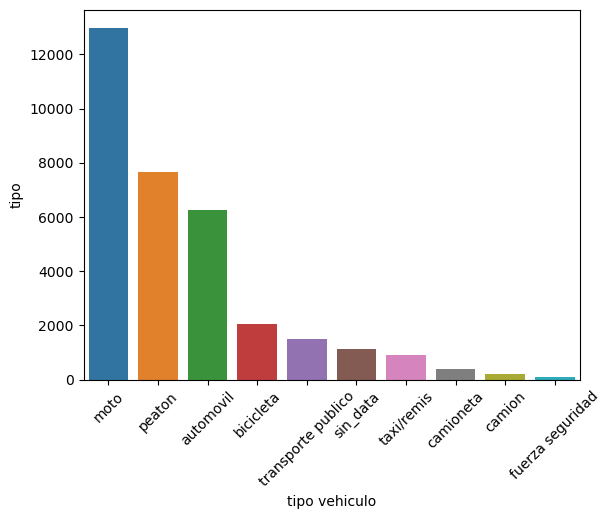

In [28]:
tipo_sin = sin_df.tipo.value_counts().to_frame().reset_index()

sns.barplot(data=tipo_sin, x=tipo_sin['index'], y=tipo_sin['tipo'])
plt.xticks(rotation=45)
plt.xlabel('tipo vehiculo')

AHORA TENGO QUE DETERMINAR QUE TIPO DE CAMPAÑA DE PREVENCIÓN VOY A HACER:
Me voy a centrar en dos campañas, una sobre el uso de casco y otra sobre el cumplimiento de la velocidad maxima

Para la primer campaña voy a revisar las edades de los involucrados en accidentes, para saber si tengo que apuntar la propaganda a cierto grupo etareo (para esto voy a usar la MEDIANA), también revisare a que hora es mas conveniente que esta propaganda aparezca. 

Para la segunda campaña voy a elegir una comuna (o una zona) y revisaré si hay un momento del año en el que haya un incremento significante de accidentes, para colocar carteles en esa zona en visperas a la fecha determinada. 



In [29]:
motos = sin_df.loc[(sin_df['tipo_colision1'].str.contains('moto'))|(sin_df['tipo'].str.contains('moto'))]

In [30]:
motos.edad.median()

30.0

In [31]:
motos.hora.value_counts().head(6)

14    884
18    882
13    874
15    870
17    868
16    848
Name: hora, dtype: int64

LA PRIMER CAMPAÑA SERA APUNTADA A EL GRUPO ETAREO DE 25 A 35 AÑOS, Y SE MOSTRARA (en caso de tener limite horario) ENTRE LAS 13hs Y LAS 18hs

PARA LA SEGUNDA CAMPAÑA, BUSCO EN QUE COMUNA HAY (PORCENTUALMENTE) MAS SINIESTROS EN VERANO QUE EN INVIERNO. LUEGO DE OBTENER ESTA COMUNA, ESTUDIO EN QUE CALLE PONER LAS SEÑALES DE PREVENCIÓN

In [32]:
motos['cant'] = 1
motos['verano'] = 0
motos.loc[motos.m<4, 'verano']=1

C:\Users\Seguridad\AppData\Local\Temp\ipykernel_7852\2594668242.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  motos['cant'] = 1
C:\Users\Seguridad\AppData\Local\Temp\ipykernel_7852\2594668242.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  motos['verano'] = 0


In [33]:
motos['verano'].value_counts()

0    9657
1    3648
Name: verano, dtype: int64

In [34]:
motos_comuna = motos.groupby(['comuna','verano'])['cant'].sum().reset_index()
motos_comuna.loc[motos_comuna.verano==0, 'cant'] = motos_comuna.cant/3
motos_comuna.head(4)

,comuna,verano,cant
0,0,0,111.666667
1,0,1,126.000000
2,1,0,402.333333
3,1,1,461.000000


<AxesSubplot:xlabel='comuna', ylabel='porcentaje_aumento_verano'>

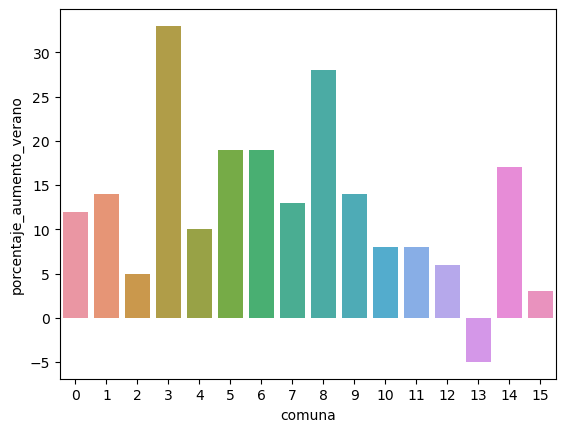

In [35]:
def porcentajes_verano (numeros):
    
    return int(((numeros.iloc[1,1]) / (numeros.iloc[0,1]))*100 - 100)


#voy a sacar cuanto sube el porcentaje de la cantidad de siniestros en verano, en comparación con "no verano"
porcent_verano = motos_comuna.groupby('comuna')[['verano','cant']].apply(porcentajes_verano).reset_index()
porcent_verano.columns = ['comuna','porcentaje_aumento_verano']
porcent_verano = porcent_verano.sort_values(by='porcentaje_aumento_verano',ascending=False)
sns.barplot(data=porcent_verano,x='comuna',y='porcentaje_aumento_verano')


VEO QUE EN LAS COMUNAS 3 y 8 AUMENTA SIGNIFICATIVAMENTE EL PORCENTAJE DE SINIESTROS EN LOS MESES 1, 2 y 3. POR ULTIMO VERE EN QUE CALLES DE ESTAS COMUNAS HAY MAS SINIESTROS EN ESTA EPOCA.

In [36]:
#SACO LAS AVENIDAS DEL ESTUDIO PORQUE APUNTO A PONER CARTELES EN CALLES, NO AVENIDAS
comuna3 = motos.loc[(motos.tipo_calle=='calle') & (motos.comuna == 3)]
comuna3.calle1.value_counts().head(5)

alberti               20
sarmiento             18
yrigoyen, hipolito    17
pavon                 16
mexico                14
Name: calle1, dtype: int64

CON ESTE RESULTADO, EN LA COMUNA 3, en las calles Alberti y Sarmiento, COLOCARIA CARTELES DE PREVENCIÓN EN EL MES DE DICIEMBRE Y LOS DEJARÍA POR 3 MESES. 

FIN DE LA ENTREGA

In [37]:
from datetime import datetime

sin_df['fecha_norm'] = sin_df['d'].astype(str) + '-' + sin_df['m'].astype(str) + '-' + sin_df['a'].astype(str)
sin_df['fecha'] = pd.to_datetime(sin_df['fecha_norm'],format='%d-%m-%Y', errors='coerce')

sin_df['nom_dia'] = sin_df['fecha'].dt.strftime('%A')

sin_df[['a','m','d','fecha','nom_dia']].sample(3)

,a,m,d,fecha,nom_dia
14488,2017,9,19,2017-09-19,Tuesday
9531,2015,6,14,2015-06-14,Sunday
13828,2017,4,8,2017-04-08,Saturday


In [38]:
mask = (sin_df.loc[(sin_df.nom_dia == 'Sunday') | (sin_df.nom_dia == 'Saturday')]).index

In [39]:
sin_df.loc[mask, 'finde'] = 1
sin_df.loc[sin_df.finde!=1, 'finde'] = 0
sin_df.finde = sin_df.finde.astype(int)
sin_df[['fecha','nom_dia','finde']].sample(10)

,fecha,nom_dia,finde
465,2015-03-04,Wednesday,0
241,2015-03-01,Sunday,1
7528,2018-02-02,Friday,0
33210,2018-05-27,Sunday,1
16558,2018-05-25,Friday,0
29290,2016-09-15,Thursday,0
1622,2015-05-18,Monday,0
31133,2017-07-26,Wednesday,0
10349,2015-04-24,Friday,0
21392,2016-11-08,Tuesday,0


<AxesSubplot:xlabel='nom_dia'>

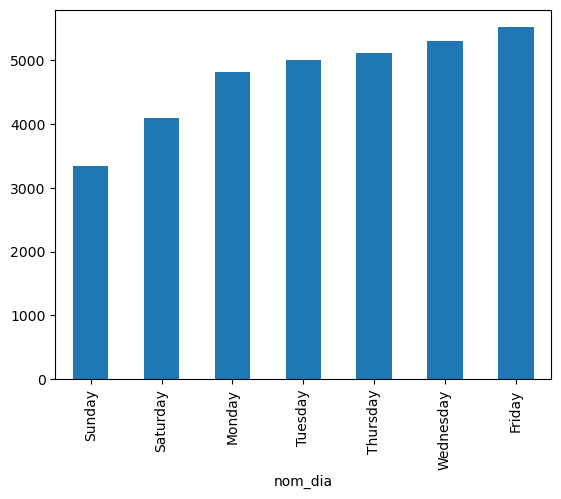

In [40]:
sin_df.groupby('nom_dia')['hora'].apply('count').sort_values().plot(kind='bar')

Como era de esperar, los fines de semana hay una baja considerable en los accidentes de transito en CABA

In [41]:
sin_df.tipo

0                      moto
1                  sin_data
2                    peaton
3                  sin_data
4                    camion
                ...        
33228                  moto
33229    transporte publico
33230             automovil
33231              sin_data
33232                  moto
Name: tipo, Length: 33162, dtype: object

In [42]:
clima = 'clima_caba.csv'
clima_df = pd.read_csv(clima)
clima_df.rename(columns={'viento;;;;;;':'viento'}, inplace=True)

In [43]:
sin_df = sin_df.merge(clima_df,how='left',left_on=['d','m','a','hora'],right_on=['d','m','a','h'])
sin_df.sample(3)

,causa,rol,tipo,sexo,edad,hora,tipo_calle,calle1,calle2,x,...,a,fecha_norm,fecha,nom_dia,finde,h,temp,hum,precip,viento
31604,lesiones,peaton,peaton,1,39.0,11,avenida,"fernandez de la cruz, f., gral. av.",varela av.,-58.438419,...,2017,19-7-2017,2017-07-19,Wednesday,0,11,12.66,56.81,0.0,9.24
25138,lesiones,conductor,moto,1,36.0,14,avenida,"scalabrini ortiz, raul av.",sin_data,-58.428540,...,2017,4-7-2017,2017-07-04,Tuesday,0,14,17.88,72.25,0.0,6.56
2864,lesiones,ciclista,bicicleta,1,23.0,17,calle,godoy cruz,sin_data,-58.426873,...,2016,23-2-2016,2016-02-23,Tuesday,0,17,28.73,68.50,0.0,2.90


In [44]:
vmod_mask = (sin_df.loc[(sin_df.viento >= 2.5) & (sin_df.viento <= 6)]).index
vmin_mask = (sin_df.loc[(sin_df.viento < 2.5)]).index
vmax_mask = (sin_df.loc[(sin_df.viento > 6)]).index


sin_df.loc[vmin_mask, 'viento'] = 0
sin_df.loc[vmod_mask, 'viento'] = 1
sin_df.loc[vmax_mask, 'viento'] = 2

sin_df.viento = sin_df.viento.astype(int)

sin_df.viento.value_counts()

1    16530
2    12674
0     3958
Name: viento, dtype: int64

In [45]:
p_mask = (sin_df.loc[(sin_df.precip >= 0.1)]).index
no_p_mask = (sin_df.loc[(sin_df.precip < 0.1)]).index

sin_df.loc[p_mask, 'precip'] = 0
sin_df.loc[no_p_mask, 'precip'] = 1

sin_df.precip = sin_df.precip.astype(int)

sin_df.precip.value_counts()

1    29634
0     3528
Name: precip, dtype: int64

In [46]:
h_mask = (sin_df.loc[(sin_df.hum >= 88)]).index
no_h_mask = (sin_df.loc[(sin_df.hum < 88)]).index

sin_df.loc[h_mask, 'hum'] = 1
sin_df.loc[no_h_mask, 'hum'] = 0

sin_df.hum = sin_df.hum.astype(int)

sin_df.hum.value_counts()

0    28918
1     4244
Name: hum, dtype: int64

In [47]:
sin_df['dif_clim'] = sin_df.viento + (2*sin_df.precip) + (sin_df.hum)

<AxesSubplot:xlabel='dif_clim'>

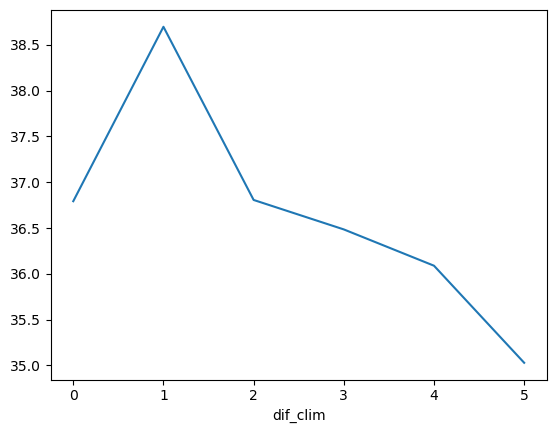

In [48]:
sin_df.groupby('dif_clim')['edad'].apply('mean').plot()

A pesar de ser muy sutíl, queda claro que a mayor dificultad climatica, la edad promedio de los participantes de un sienestro baja, esto evidencia que a mayor edad, hay un mayor control del vehiculo en situaciones climaticas desfavorables. (el valor "0" de dificultad climatica tiene muy pocos registros, no es significativa la cantidad)

In [49]:
sin_df['cant'] = 1
sin_df.groupby('dif_clim')['cant'].sum()

dif_clim
0      211
1      871
2     5104
3    14807
4    10955
5     1214
Name: cant, dtype: int64

Resta definir (o estudiar) si en general la situacion climatica mas comun es la "3" y la "4" o si hay mas siniestros por culpa de esta condición y por eso aparece mucho mas frecuentemente ese escenario. En resumen, hay que ver si es un resultado normal el de esta frecuencia de condiciones climaticas comparando este resultado con el de otro set de datos que no involucre accidentes vehiculares (utilizando las mismas escalas para humedad, presión y precipitación)

In [53]:
import geopandas as gpd
import geopandas.tools as gptools
import contextily as ctx

VEO MAPA CON TODOS LOS SINIESTROS PARA COMPARARLO CON UN MAPA DE LOS SINIESTROS LOS VIERNES, SABADOS Y DOMINGOS A LA NOCHE

C:\Users\Seguridad\AppData\Roaming\Python\Python39\site-packages\contextily\tile.py:581: UserWarning: The inferred zoom level of 29 is not valid for the current tile provider (valid zooms: 0 - 18).
  warnings.warn(msg)


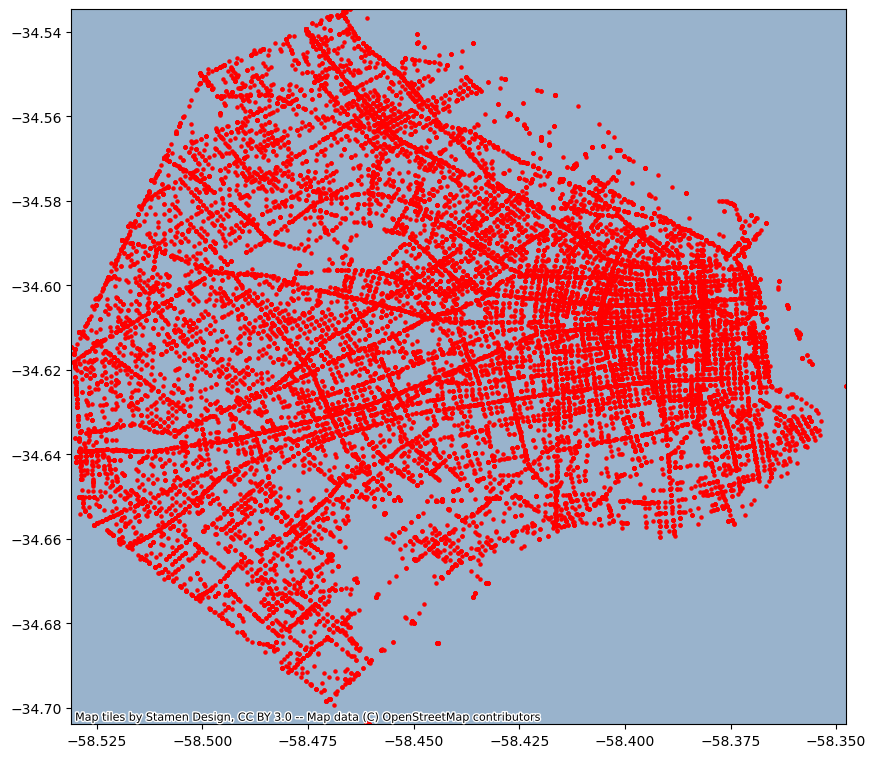

In [57]:
fig, ax = plt.subplots(figsize=(10,10))

if 'world' in locals():
    world.plot(ax=ax, color='lightgray')

geometry = gpd.points_from_xy(sin_df['x'], sin_df['y'])
gdf = gpd.GeoDataFrame(sin_df, geometry=geometry)

gdf.crs = 'EPSG:4326'
gdf.plot(ax=ax, color='red', markersize=5)


xmin = sin_df.loc[(sin_df.x)<-1].x.min()
xmax = sin_df.loc[(sin_df.x)<-1].x.max()

ymin = sin_df.loc[(sin_df.y)<-1].y.min()
ymax = sin_df.loc[(sin_df.y)<-1].y.max()

#ax.set_xlim(xmin, xmax)
#ax.set_ylim(ymin, ymax)
ax.axis([xmin,xmax,ymin,ymax])

ctx.add_basemap(ax)

plt.show()

In [55]:
noche_finde = sin_df.loc[(sin_df.nom_dia == 'Friday') | (sin_df.nom_dia == 'Saturday') | (sin_df.nom_dia == 'Sunday')]
noche_finde = noche_finde.loc[(noche_finde.h>19)]

C:\Users\Seguridad\AppData\Roaming\Python\Python39\site-packages\contextily\tile.py:581: UserWarning: The inferred zoom level of 29 is not valid for the current tile provider (valid zooms: 0 - 19).
  warnings.warn(msg)


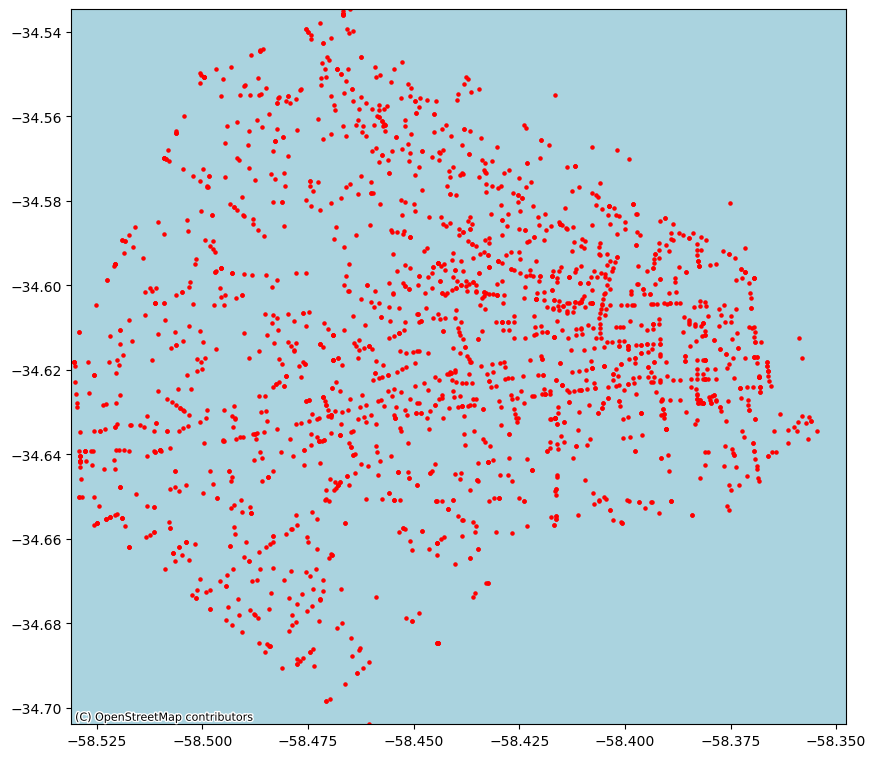

In [56]:
fig, ax = plt.subplots(figsize=(10,10))

if 'world' in locals():
    world.plot(ax=ax, color='lightgray')

geometry = gpd.points_from_xy(noche_finde['x'], noche_finde['y'])
gdf = gpd.GeoDataFrame(noche_finde, geometry=geometry)

gdf.crs = 'EPSG:4326'
gdf.plot(ax=ax, color='red', markersize=5)


xmin = sin_df.loc[(sin_df.x)<-1].x.min()
xmax = sin_df.loc[(sin_df.x)<-1].x.max()

ymin = sin_df.loc[(sin_df.y)<-1].y.min()
ymax = sin_df.loc[(sin_df.y)<-1].y.max()

#ax.set_xlim(xmin, xmax)
#ax.set_ylim(ymin, ymax)
ax.axis([xmin,xmax,ymin,ymax])

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

plt.show()

No encuentro areas con especial cantidad de siniestros en el caso "fin de semana a la noche"